# Run with Shell #

In [35]:
!pip install --user git+https://github.com/LAL/trackml-library.git

  Cloning https://github.com/LAL/trackml-library.git to /tmp/pip-req-build-5hy1ec1b
  Running command git clone -q https://github.com/LAL/trackml-library.git /tmp/pip-req-build-5hy1ec1b
  Created wheel for trackml: filename=trackml-3-py2.py3-none-any.whl size=13512 sha256=d3dcfe641ab736bb245bbe50b9093c9317a81db5c2a02010e70019d725bb9996
  Stored in directory: /tmp/pip-ephem-wheel-cache-qwh65kt5/wheels/0f/9a/5f/be8818e35f0d18b449158a62387337b237826b5cc21a1b28eb
Successfully built trackml


In [1]:
# Clonning 
!git clone https://github.com/stonescenter/track-particles.git cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 94 (delta 41), reused 94 (delta 41), pack-reused 0
Unpacking objects: 100% (94/94), done.
cloned-repo  sample_data


In [2]:
%cd cloned-repo/

/content/cloned-repo


In [5]:
! python main-paralel.py

Using TensorFlow backend.
[Data] data loaded from  ./dataset/phi025-025_eta025-025_filtered.csv
[Data] shape datas X:  (15192, 16)
[Data] shape data y:  (15192, 3)
[Data] len data total: 15192
[Data] shape data X_train.shape: (10634, 4, 3)
[Data] shape data X_test.shape: (4558, 4, 3)
[Data] shape data y_train.shape: (10634, 3)
[Data] shape data y_test.shape: (4558, 3)



2020-02-07 17:18:59.317715: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2020-02-07 17:18:59.319932: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x2c0cbc0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-02-07 17:18:59.320010: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-02-07 17:18:59.346835: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-02-07 17:18:59.394811: E tensorflow/stream_execu

# Run with NoteBooks #

In [10]:
import sys
import os
import json

from core.data.data_loader import *
from core.models.lstm import ModelLSTM, ModelLSTMParalel
from core.data.data_loader import FeatureType, Dataset


from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import set_random_seed

import keras.backend as K
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


## loading Configurartion ##


In [11]:
# load some configurations configurations of model and others

configs = json.load(open('config-paralel.json', 'r'))
save_dir = configs['paths']['save_dir']
save_fname = os.path.join(save_dir, 'architecture-%s.png' % configs['model']['name'])
save_fnameh5 = os.path.join(save_dir, 'model-%s.h5' % configs['model']['name'])
print(save_fname) 
print(save_fnameh5)
print('OK reading of json file')

results/architecture-lstm-paralel.png
results/model-lstm-paralel.h5
OK reading of json file


## Setup Data ##

In [12]:
# reading path of data
#path = './dataset/phi025-025_eta025-025/phi025-025_eta025-025_filtered.csv'
path = configs['data']['filename']
path

'./dataset/phi025-025_eta025-025_filtered.csv'

In [13]:
data = Dataset(path, KindNormalization.Zscore)

X, X_, y = data.prepare_training_data(FeatureType.Divided, normalise=True,
                                                  cilyndrical=False)
#X, y = data.prepare_training_data(FeatureType.Positions, normalise=False,
#                                                  cilyndrical=False)

X.head()

[Data] data loaded from  ./dataset/phi025-025_eta025-025_filtered.csv
[Data] shape datas X:  (15192, 16)
[Data] shape data y:  (15192, 3)
[Data] len data total: 15192


,x_0,y_0,z_0,x_1,y_1,z_1,x_2,y_2,z_2,x_3,y_3,z_3
0,-0.197514,0.447192,0.215793,-0.207645,0.504261,0.094703,-0.209314,0.480264,0.034145,-0.223646,0.405745,-0.000333
1,-0.225104,0.905615,0.454577,-0.241666,1.113409,0.434772,-0.235227,1.182940,0.395443,-0.259084,1.195713,0.362829
2,-0.219544,-0.252188,0.829579,-0.215628,-0.310552,0.963034,-0.215073,-0.304692,0.962387,-0.224862,-0.266718,0.952794
3,3.086830,5.527004,1.322880,3.267902,4.838781,1.578658,3.266429,4.533334,1.620158,3.406857,4.364378,1.654012
4,-0.195694,0.416933,0.610438,-0.207160,0.495587,0.689542,-0.218343,0.513846,0.680414,-0.234667,0.513960,0.667967


In [14]:
X_.head()

,value_0,value_1,value_2,value_3
0,-0.196225,-0.272555,-0.245471,-0.295344
1,-0.212564,-0.248243,-0.182892,-0.201048
2,-0.114694,-0.199678,-0.186903,-0.249061
3,-0.096597,2.961432,2.356338,1.588075
4,-0.185638,-0.188648,-0.058163,-0.256392


In [15]:
# existe dados vazios?
X.isnull().values.any()
#dataset.isnull().sum()
X.isna().sum()

x_0    0
y_0    0
z_0    0
x_1    0
y_1    0
z_1    0
x_2    0
y_2    0
z_2    0
x_3    0
y_3    0
z_3    0
dtype: int64

In [16]:
# reshape data     
time_steps =  configs['model']['layers'][0]['input_timesteps']  # the number of points or hits
num_features = configs['model']['layers'][0]['input_features']  # the number of features of each hits

X = data.reshape3d(X, time_steps, num_features)
X_ = data.reshape3d(X_, time_steps, 1)

# always the same info 
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_test, X_train_, X_test_, y_train, y_test = train_test_split(X, X_, y,
                                                                    test_size=1-0.8, random_state=42)

print('[Data] shape X_train ', X_train.shape)
print('[Data] shape X_test ', X_test.shape)
print('[Data] shape y_train ', y_train.shape)
print('[Data] shape y_test ', y_test.shape)



[Data] shape X_train  (12153, 4, 3)
[Data] shape X_test  (3039, 4, 3)
[Data] shape y_train  (12153, 3)
[Data] shape y_test  (3039, 3)


In [0]:
   
def no_gpu():
    import os
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"
    import tensorflow as tf

    config=tf.ConfigProto(log_device_placement=True)
    sess = tf.Session(config=config)
    set_session(sess)
    

def gpu():
    import tensorflow as tf
    from tensorflow import set_random_seed

    import keras.backend as K
    from keras.backend.tensorflow_backend import set_session
    
    #configure  gpu_options.allow_growth = True in order to CuDNNLSTM layer work on RTX
    config = tf.ConfigProto(device_count = {'GPU': 0})
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

    set_random_seed(1)

#gpu()

## Create Model ##

In [20]:
# geramos o modelo
model = ModelLSTMParalel(configs)

model.build_model()
  

[Model] Creating model..



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

[Model] Model Compiled with structure: [<tf.Tensor 'input_1:0' shape=(?, 4, 3) dtype=float32>, <tf.Tensor 'input_2:0' shape=(?, 4, 1) dtype=float32>]
Time taken: 0:00:01.041043


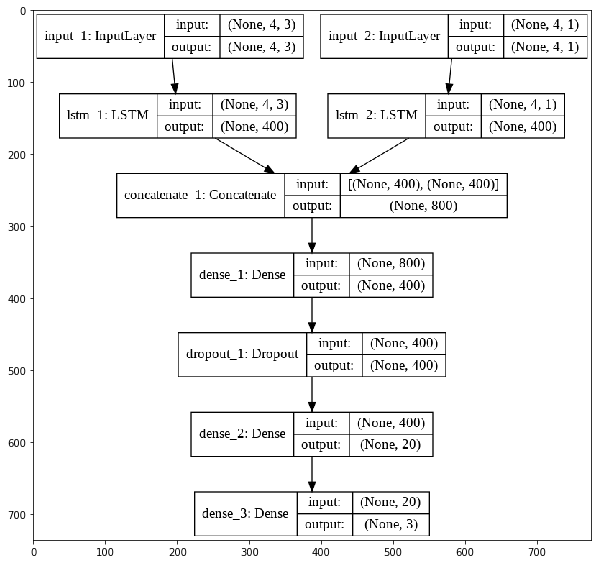

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

fig = plt.figure(figsize=(10, 14))
img=mpimg.imread('results/architecture-lstm-paralel.png')
imgplot = plt.imshow(img)
plt.show()


## Training Model ##

In [23]:
# in-memory training
x_train = [X_train, X_train_]
history = model.train(
    x=x_train,
    y=y_train,
    epochs = configs['training']['epochs'],
    batch_size = configs['training']['batch_size']

)

[Model] Training Started
[Model] 20 epochs, 128 batch size
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 8142 samples, validate on 4011 samples
Epoch 1/20




8142/8142 [==============================] - 13s 2ms/step - loss: 0.1160 - acc: 0.8600 - val_loss: 0.0617 - val_acc: 0.8983
Epoch 2/20
8142/8142 [==============================] - 11s 1ms/step - loss: 0.0481 - acc: 0.9100 - val_loss: 0.0296 - val_acc: 0.9287
Epoch 3/20
8142/8142 [==============================] - 11s 1ms/step - loss: 0.0337 - acc: 0.9216 - val_loss: 0.0281 - val_acc: 0.9237
Epoch 4/20
8142/8142 [==============================] - 11s 1ms/step - loss: 0.0269 - acc: 0.9390 - val_loss: 0.0391 - val_acc: 0.9437
Epoch 5/20
8142/8142 [==============================] - 11s 1ms/step - loss: 0.0226 - acc: 0.9466 - val_loss: 0.0285 - val_acc: 0.9663
[Model] Model for inference saved at results/model-lstm-paralel.h5
[Model] Model Architecture saved at results/archite

## Evaluate The model ##


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])
[Ouput] Validation accuracy: 0.9663425578467123, loss: 0.02854753355722019


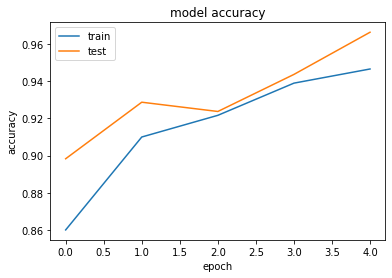

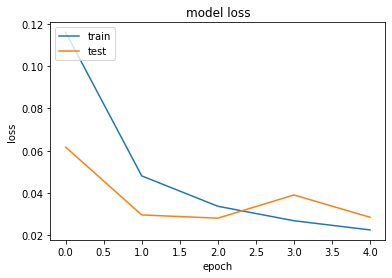

[Output] resulta saved at %s results/eval-loss.png


In [24]:
#evaluate the model
from core.utils.metrics import *
evaluate_training(history,save_dir)

## Prediction ##
We concatenate features to predict one hit.

In [25]:
# Prediction
import numpy as np
from core.utils.metrics import *
from core.utils.utils import *

x_test = [X_test, X_test_]

predicted = model.predict_one_hit(x_test)


[Model] Predicting Point-by-Point...
[Model] Shape predict result (3039, 3) size 9117


In [26]:
# Convert to original data
#y_predicted = data.reshape2d(predicted, 1)
   
y_predicted = np.reshape(predicted, (predicted.shape[0]*predicted.shape[1], 1))
y_true_ = data.reshape2d(y_test, 1)

result = calc_score(y_true_, y_predicted, report=True)
r2, rmse, rmses = evaluate_forecast(y_test.values, predicted)
summarize_scores(r2, rmse,rmses)


[Output] ---Regression Scores--- 
	R_2 statistics        (R2)  = 0.973
	Root Mean Square Error(RMSE) = 0.161
	Mean Absolute Error   (MAE) = 0.086

RMSE:		[0.161] 
RMSE features: 	[0.13, 0.13, 0.21] 
R^2  features:	[0.98, 0.98, 0.95] 


## Calculate Distances( Process very EXPENSIVE) ##
Google may block your account by using a lot of CPU for calculate distantes of a lot of matrixs.


In [27]:
from scipy.spatial import distance
import numpy as np


print('[Data] shape y_test ', y_test.shape)
print('[Data] shape predicted ', predicted.shape)
print('[Data] processing the neardest points between y_real and y_pred...' )

# shortest point with y_pred e y_real
near_points = get_shortest_points(y_test, predicted)
y_near_points = pd.DataFrame(near_points)

#print(y_near_points.head())
print(y_near_points.shape)


[Data] shape y_test  (3039, 3)
[Data] shape predicted  (3039, 3)
[Data] processing the neardest points between y_real and y_pred...
(3039, 3)


In [28]:
# we need to transform to original data
y_test_orig = data.inverse_transform(y_test)
y_predicted_orig = data.inverse_transform(predicted)
y_near_orig = data.inverse_transform(y_near_points)

#print(y_test_orig.shape)
#print(y_predicted_orig.shape)

print('[Data] processing distances for %s vectors..' % y_predicted_orig.shape[0])
dist0 = calculate_distances_matrix(y_predicted_orig, y_test_orig)
#dist1 = calculate_distances_matrix(y_predicted_orig, y_near_orig)
dist1 = calculate_distances_matrix(y_test_orig, y_near_orig)
print('[Data] finished distances..')
print(dist0[0:10])

print(dist1[0:10])


[Data] processing distances for 3039 vectors..
[Data] finished distances..
[3.66040755 6.69628445 9.6843639  6.02464742 5.47887828 4.11394606
 4.59503543 4.49222435 3.55848211 4.64133232]
[2.41196904 5.40000153 6.52333772 6.56587978 6.07278975 4.03214015
 3.30557408 4.8166264  0.76005132 4.56062734]


## Ploting Results ##

In [29]:
import plotly.figure_factory as ff
# Group data together
#hist_data = [d1.values.flatten(), d2.values.flatten()]
hist_data = [dist0, dist1]

group_labels = ['Distances predicted', 'Distances Approx']

# Create distplot with custom bin_size
fig = ff.create_distplot(hist_data, group_labels, bin_size=.25, curve_type='normal')
#fig = ff.create_distplot(hist_data, group_labels, show_curve=True, bin_size=.2)

fig['layout'].update(title='Distances')

fig.show()

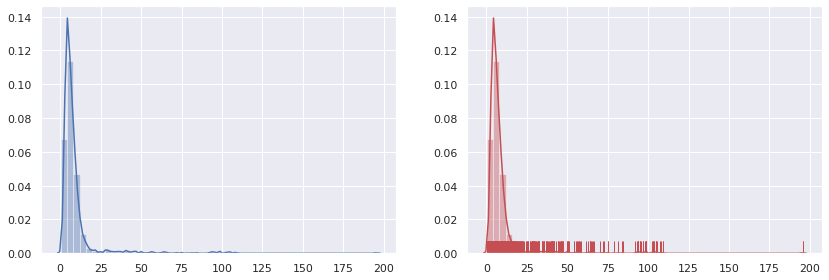

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns, numpy as np
from pylab import *

def plot_distances(d1, d2):
    
    sns.set(rc={"figure.figsize": (14, 10)})

    subplot(2,2,1)
    ax = sns.distplot(d1)

    subplot(2,2,2)
    ax = sns.distplot(d1, rug=True, hist=True, color="r")

    plt.show()
    '''
    fig,axes=plt.subplots(1,2)
    sns.distplot(d1,ax=axes[0])
    plt.grid(True)
    sns.distplot(d2,rug=True,ax=axes[1], color="r")
    plt.show()
    '''


plot_distances(dist0, dist1)

In [31]:
#Export data to plot
X, X_, y = data.prepare_training_data(FeatureType.Divided, normalise=False,
                                                  cilyndrical=False)
X_train, X_test, X_train_, X_test_, y_train, y_test = train_test_split(X, X_, y,
                                                                       test_size=1-0.8, random_state=42)

y_pred = pd.DataFrame(y_predicted_orig)
y_true = pd.DataFrame(y_test_orig)


y_true.to_csv(os.path.join(save_dir, 'y_true.csv'), header=False, index=False)
y_pred.to_csv(os.path.join(save_dir, 'y_pred.csv'), header=False, index=False)
X_test.to_csv(os.path.join(save_dir, 'x_test.csv'), header=False, index=False)
print('[Output] Results saved at %', save_dir)

[Data] shape datas X:  (15192, 16)
[Data] shape data y:  (15192, 3)
[Data] len data total: 15192
[Output] saving results ...


## Reading the data to Plot ##


In [0]:
path1 = 'results/x_test.csv'
path2 = 'results/y_true.csv'
path3 = 'results/y_pred.csv'

x_test = pd.read_csv(path1, header=None)
y_test = pd.read_csv(path2, header=None)
y_pred = pd.read_csv(path3, header=None)

test = pd.concat([x_test, y_test], axis = 1, ignore_index = True)
pred = pd.concat([x_test, y_pred], axis = 1, ignore_index = True)
test.name = 'real'
pred.name = 'predict'

In [0]:
import sys
import pandas as pd

from core.utils.tracktop import *

track_plot_xyz([test, pred], n_tracks = 100, 
                title='Track Prediction #5 Hit')